In [280]:
# %reload_ext autoreload
# %autoreload 2

In [314]:
import sys
sys.path.append("../")
from Utils.visualizations_utils import Visualization as vis

In [144]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.restoration import estimate_sigma
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.exposure import rescale_intensity
from skimage.feature import local_binary_pattern
import pywt

base_path = "../CBIS-DDSM_Clean_Data/"
train = pd.read_csv(base_path + "train_full.csv")

In [145]:
image_path = os.path.join("../",(train["image_path"].iloc[0]))
image_path

'../CBIS-DDSM_Clean_Data/labeled_images_png/1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547_full.png'

In [146]:
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
images = {}
images["original"] = original_image

### Background Removal: Otsu Segemntation and Morphological Closing

In [147]:
def background_removal(image):
    '''
        Removes edge of whole image, blur to find Otsu threshold, finds closed mask, 
        find the largest connected region and generate Otsu mask to remove background and leave only breast
    '''
 
    # resize to remove a contour of the whole image to remove some of the marks of x-rays that are not the breast
    height, width = image.shape[:2]
    image = image[45:height-45, 45:width-45]

    # smooth image
    blur_img = cv2.GaussianBlur(image, (5,5), 0)

    # gets Otsu threshold 
    _, thresh = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

    # apply morphological closing to make sure parts of the breast are not removed 
    kernel = np.ones((15, 15), np.uint8) 
    closed_img = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Identify connecting regions for each pixel edge and corner (8) of binary image 
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed_img, connectivity=8)

    # find the largest component that is connected
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    
    # generate mask of black background
    mask = (labels == largest_label).astype(np.uint8) * 255
    breast_img = cv2.bitwise_and(image, image, mask=mask)

    return closed_img, image, mask, breast_img

In [148]:
closed_mask, original, mask, breast_img = background_removal(original_image)

In [149]:
background_data = {
    "Original": original,
    "Closed Mask": closed_mask,
    "Otsu Mask": mask,
    "Clean Image": breast_img
}

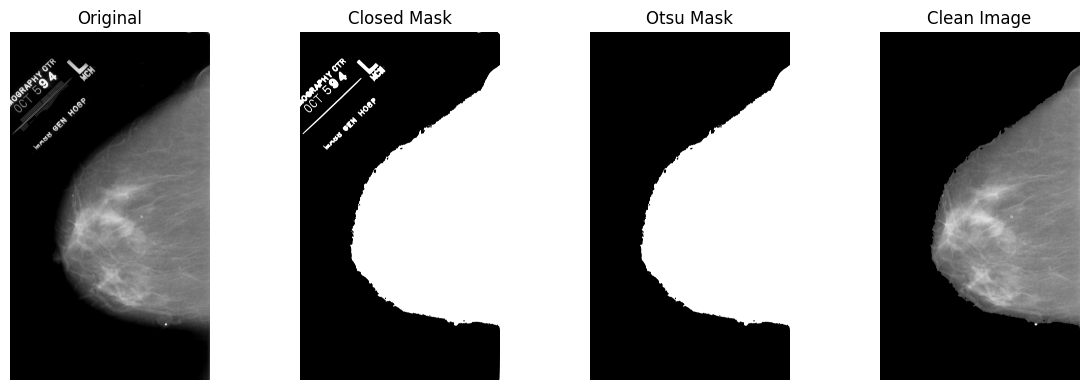

In [150]:
vis.vis_plots(background_data)

### Crop and Resizing Using Countours

In [151]:
def crop(image, breast_mask):
    
    # find contours of breast image using the mask. 
    # - RETR_EXTERNAL: defines only external countour of the biggest section, 
    # - CHAIN_APPROX_SIMPLE: saves only non redundant and the simplest points of the countour 
    # source: https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    contours, _ = cv2.findContours(breast_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # checks for non-countour
    if len(contours) == 0:
        return image

    # find the countour area
    # source: https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
    area = max(contours, key=cv2.contourArea)
    
    # find the bounding box
    x, y, w, h = cv2.boundingRect(area)

    # crops image using bounding box
    cropped = image[y:y+h, x:x+w]
    
    return cropped

      

In [152]:
cropped = crop(breast_img, mask)

In [153]:
cropped_data = {
    "No Background": breast_img,
    "Cropped": cropped
}

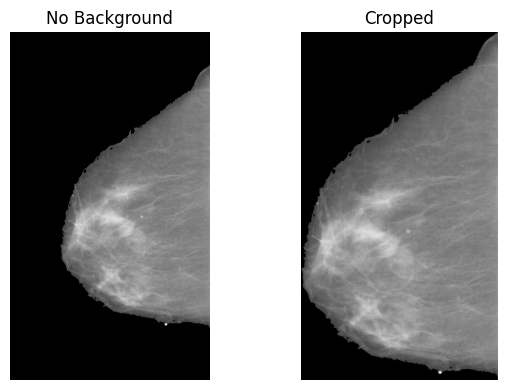

In [154]:
vis.vis_plots(cropped_data)

### Noise removal: Gaussian Blur and Wavelet Transform Soft Threshold

In [155]:
# Noise removal function using simple Gaussian Blur
def noise_reduction_GB(image):
    '''Denoise image using the parameters:
        - image 
        - kernel
        - sigma value for denoising
    '''
    return cv2.GaussianBlur(image, (5,5), 0)

In [224]:
# Noise removal using Wavelet Soft Denoiser 
def noise_reduction_WT(image):
    '''Denoise image by: 
       - calculating coefficients of approximation and detail
       - calculating sigma value
       - calculating and applying soft thresholding value to coefficients 
       - and reconstructing image using coefficinets'''
    
    # Calculate coefficients for the image using wavedec2 for 2D (image) decomposition 
    # using the  Daubechies wavelet db1 (Haar wavelet of interval of 0-1)  
    init_coeffs = pywt.wavedec2(image, wavelet="db1", level=2)

    # calculate sigma of the detail coefficients
    sigma = estimate_sigma(image, channel_axis=None)

    # calculate initial threshold
    init_threshold = sigma * np.sqrt(2 * np.log2(image.size))

    # iterate through detail coefficients to apply threshhold function using the initial threshold
    new_coeffs = [init_coeffs[0]]

    for level in init_coeffs[1:]:
        tuple_vals = tuple(pywt.threshold(detail, init_threshold, mode='soft') for detail in level)
        new_coeffs.append(tuple_vals)

    # Reconstruct image using waverec2
    denoised_img = pywt.waverec2(new_coeffs, wavelet="db1")
    reconstructed = denoised_img[:image.shape[0], :image.shape[1]]
    
    return reconstructed

In [225]:
denoised_GB = noise_reduction_GB(cropped)
denoised_WT = noise_reduction_WT(cropped)

In [226]:
denoised_data = {
    "Gaussian Blur": denoised_GB,
    "Wavelet Transform": denoised_WT
}

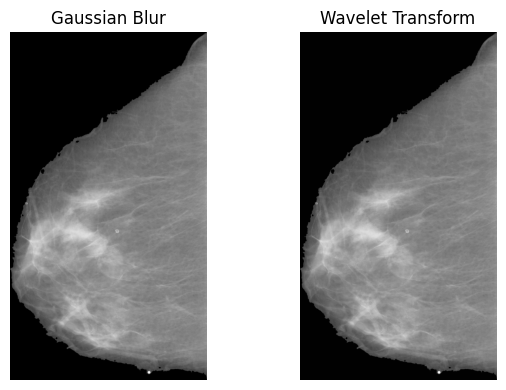

In [227]:
vis.vis_plots(denoised_data)

In [228]:
# calcualte diference between original image and each denoised image to be visualized
noise_diff = {}
noise_diff["Denoised By GB"] = vis.img_difference(cropped, denoised_GB)
noise_diff["Denoised By WT"] = vis.img_difference(cropped, denoised_WT)

PSNR Value: 46.13852334622428
PSNR Value: 46.08353638419814


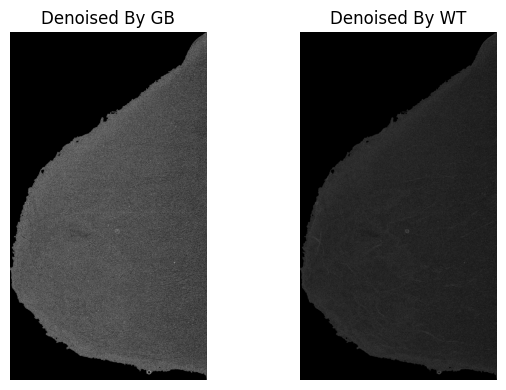

In [229]:
vis.vis_plots(noise_diff)

### Contrast Enhancement using CLAHE

In [230]:
def contrast_enhancement(image):
    # code provenance 
    # https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

    # verify the image is in gray scale
    if len(image.shape) == 3:  # If color image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # verify image is intiger type 
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
        image = image.astype(np.uint8)

    # initialize CLAHE and apply to image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clh_image = clahe.apply(image)
    
    return clh_image

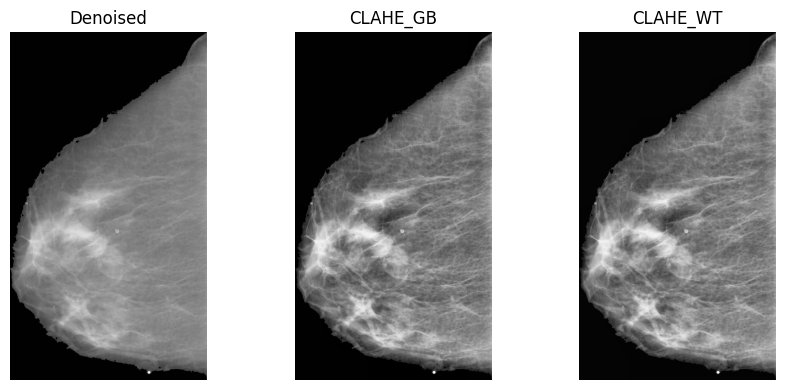

In [231]:
contrast_enhanced_WT = contrast_enhancement(denoised_WT)
contrast_enhanced_GB = contrast_enhancement(denoised_GB)

contrast_data = {
    "Denoised": denoised_WT,
    "CLAHE_GB": contrast_enhanced_GB,
    "CLAHE_WT": contrast_enhanced_WT,
}
vis.vis_plots(contrast_data)

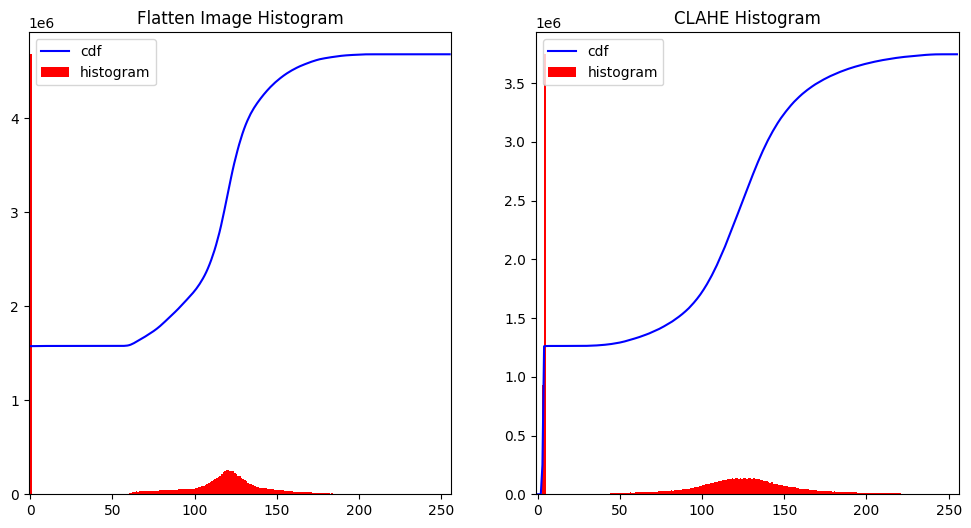

In [232]:
# create a histogram of the previously preprocessed image 
hist, bins = np.histogram(denoised_WT.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Flatten Image Histogram")
plt.plot(cdf_normalized, color = 'b')
plt.hist(denoised_WT.flatten(),256,[0,256], color = 'r')
plt.xlim([-1,256])
plt.legend(('cdf','histogram'), loc = 'upper left')


# create a histogram of the CLAHE image 
hist_clahe, bins_clahe = np.histogram(contrast_enhanced.flatten(),256,[0,256])

cdf_clahe = hist_clahe.cumsum()
cdf_normalized_clahe = cdf_clahe * float(hist_clahe.max()) / cdf_clahe.max()

plt.subplot(1,2,2)
plt.title("CLAHE Histogram")
plt.plot(cdf_normalized_clahe, color = 'b')
plt.hist(contrast_enhanced.flatten(),256,[0,256], color = 'r')
plt.xlim([-1,256])
plt.legend(('cdf','histogram'), loc = 'upper left')

plt.show()

### Edge Enhancement using Guided Filter

In [233]:
def edge_enhancement(guide_image, input_image, radius=8, epsilon = 0.0001):    

    '''Use guided filter to smooth image and keep edges sharp. Uses input image to be filter and as guide for pixel smoothness.
        - guided image
        - input image
        - kernel radius
        - regularization value
    '''

    # Normalize value
    guide_image = guide_image.astype(np.float32) / 255.0
    input_image = input_image.astype(np.float32) / 255.0
    
    # compute local mean: guidance and input image
    mean_guide = cv2.boxFilter(guide_image, -1, (radius, radius)) # depth is -1 for source depth
    mean_input = cv2.boxFilter(input_image, -1, (radius, radius)) # depth is -1 for source depth
    mean_g_i = cv2.boxFilter(guide_image * input_image, -1, (radius, radius)) # mean of product of both images
    mean_g_g = cv2.boxFilter(guide_image * guide_image, -1, (radius, radius))# compute loacl mean of product of guide image
    
    # calculate variance 
    covar_g_i = mean_g_i - mean_guide * mean_input # of the product of loacl means of both images  against local mean of the product of both images
    var_g = mean_g_g - mean_guide * mean_guide # of guidance image 

    # calculate coefficinets using means , covariance and variance
    alpha = covar_g_i / (var_g + epsilon)
    beta = mean_input - alpha * mean_guide

    # calculate mean of coefficinets
    mean_alpha = cv2.boxFilter(alpha, -1, (radius, radius))
    mean_beta = cv2.boxFilter(beta, -1, (radius, radius))

    # apply mean of alpha to the guide image and add mean of beta
    filtered = mean_alpha * guide_image + mean_beta

    # convert back to intigers
    filtered = (filtered * 255).astype(np.uint8)

    return filtered

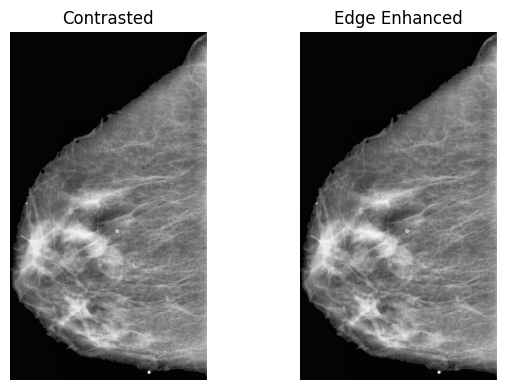

In [234]:
edge_enhanced = edge_enhancement(contrast_enhanced, contrast_enhanced)
edge_data = {
    "Contrasted": contrast_enhanced,
    "Edge Enhanced": edge_enhanced
}
vis.vis_plots(edge_data)

In [235]:
# calculate differences and PSNR value  
edge_diff = {
    "Contrast Enhanced Image": contrast_enhanced,
    "Edge Diff eps=0.01": vis.img_difference(contrast_enhanced, edge_enhancement(contrast_enhanced, contrast_enhanced, epsilon=0.01)),
    "Edge Diff eps=0.001": vis.img_difference(contrast_enhanced, edge_enhancement(contrast_enhanced, contrast_enhanced, epsilon=0.001)),
    "Edge Diff eps=0.0002": vis.img_difference(contrast_enhanced, edge_enhancement(contrast_enhanced, contrast_enhanced, epsilon=0.0002)),
    "Edge Diff eps=0.0001": vis.img_difference(contrast_enhanced, edge_enhancement(contrast_enhanced, contrast_enhanced, epsilon=0.0001)),
    "Edge Diff eps=0.00005": vis.img_difference(contrast_enhanced, edge_enhancement(contrast_enhanced, contrast_enhanced, epsilon=0.00005))
}

PSNR Value: 37.87894839091729
PSNR Value: 40.8048199472044
PSNR Value: 45.96826604036396
PSNR Value: 48.8478480590253
PSNR Value: 51.52864837872996


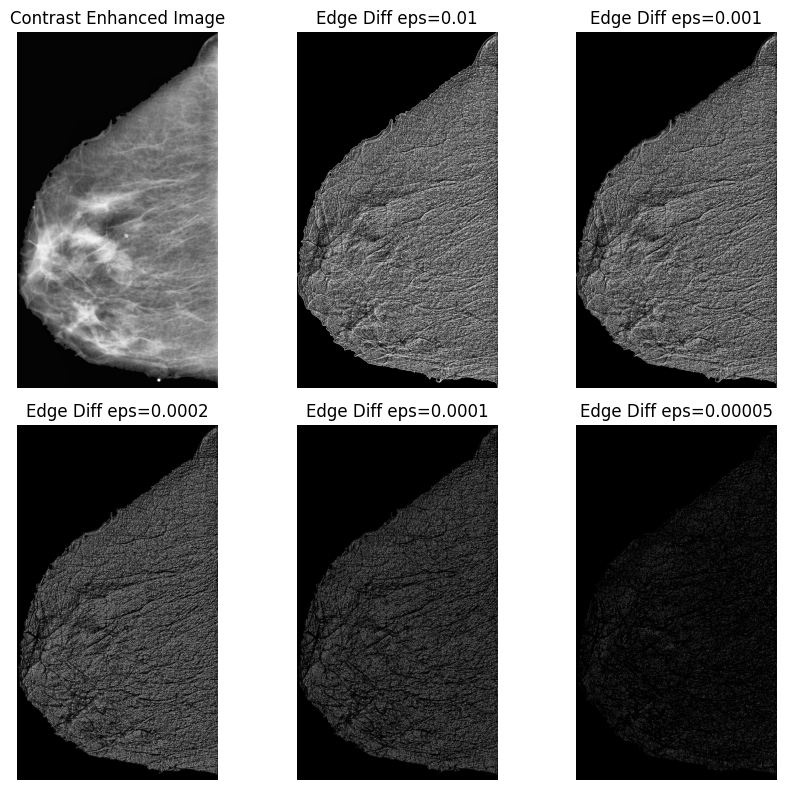

In [236]:
vis.vis_plots(edge_diff)

### Local Binary Pattern 

In [237]:
def lbp_texturizer(image, n_points=8, radius=1):
    '''Calculate the local binary pattern of an image: checks for sourronding points of the kernel
        and gives a binary value depending if bigger or smaller than the center point. Parameters are:
        - image
        - number of points around center point
        - radius of kernel
    '''
    # convert to gray scale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # calculate local binary pattern
    lbp = local_binary_pattern(image, n_points, radius)

    # normalize image for visualization
    lbp_img = np.uint8(255 * (lbp - lbp.min()) / (lbp.max() - lbp.min()))

    return lbp_img

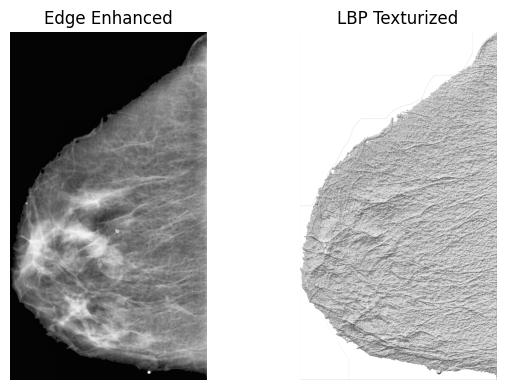

In [238]:
lbp_texture = lbp_texturizer(edge_enhanced)
lbp_data = {
    "Edge Enhanced": edge_enhanced,
    "LBP Texturized": lbp_texture
}
vis.vis_plots(lbp_data)

### Resize

In [272]:
import tensorflow as tf
def resize(image, is_resnet_vgg=False, custom_cnn_size=256, resnet_vgg_size=224, is_lbp=False):
    
    '''
    Resize an image to fit a custom CNN, ResNet and VGG models
    Parameters:
        image: image to be resized
        custom_cnn: Boolean stating if the size is for custom CNN
        resnet_vgg: Boolean stating if the size is for ResNet/VGG models
    '''

    # convert image to tensorflow image
    img = tf.image.convert_image_dtype(image, tf.float32)

    # Adds  3rd channel
    if img.ndim == 2:
        img = tf.expand_dims(img, axis=-1)

    if is_lbp:
            method = "nearest"
    else:
        method = "bilinear"
        
    if is_resnet_vgg == False:
            
        # resize image and add pad to keep image proportions
        # source https://www.tensorflow.org/api_docs/python/tf/image/resize_with_pad
        resized_img = tf.image.resize_with_pad(img, custom_cnn_size, custom_cnn_size, method=method)

        # normalize image
        # source https://www.tensorflow.org/api_docs/python/tf/clip_by_value
        input_resized_img = tf.clip_by_value(resized_img, 0.0, 1.0)
        
    else:
        # converts image to RGB for Resnet/VGG input
        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)
        
        # resize image and add pad to keep image proportions
        # https://www.tensorflow.org/api_docs/python/tf/image/resize
        resized_img = tf.image.resize_with_pad(img, resnet_vgg_size, resnet_vgg_size, method=method)

        # normalize image
        # source https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input
        input_resized_img = tf.keras.applications.resnet50.preprocess_input(resized_img * 255.0)

    return input_resized_img, resized_img

In [273]:
input_img, resized_custom = resize(lbp_texture, is_resnet_vgg=False)
print("Custom CNN image shape:", resized_custom.shape)

Custom CNN image shape: (256, 256, 1)


In [274]:
input_img, resized_RV = resize(lbp_texture, is_resnet_vgg=True)
print("ResNet/VGG image shape:", resized_RV.shape)

ResNet/VGG image shape: (224, 224, 3)


In [275]:
print(lbp_texture.shape)

(4962, 2801)


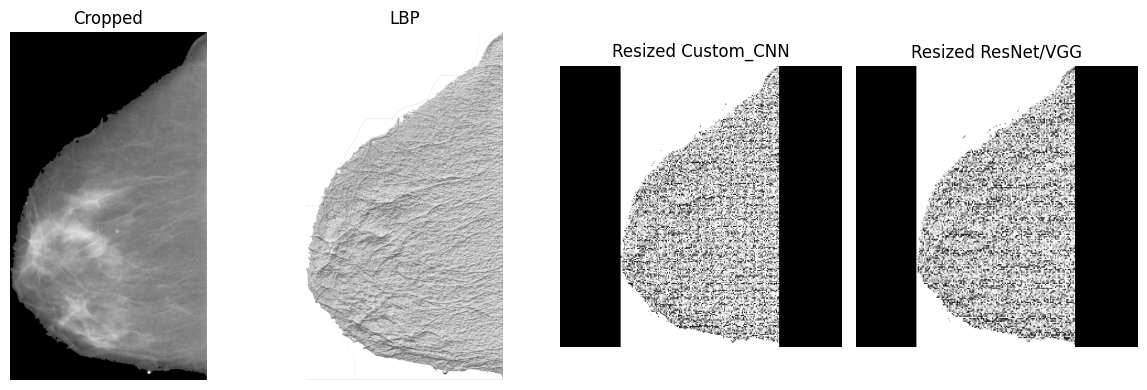

In [276]:
resized_data = {
    "Cropped": cropped,
    "LBP": lbp_texture,
    "Resized Custom_CNN": resized_custom,
    "Resized ResNet/VGG": resized_RV
}
vis.vis_plots(resized_data)

# Image Preprocessing

In [38]:
op_all = ["background_removal", "crop", "noise_reduction", "contrast_enhancement", "edge_enhancement", "lbp_texturizer"]

In [322]:
def image_preprocessing(image, 
                       preprocessing_techniques,
                       is_resnet_vgg=False,
                       custom_cnn_size=256, 
                       resnet_vgg_size=224
                       ):
    
    img = image.copy()
    breast_mask = None
    is_lbp = False
    
    if preprocessing_techniques["apply_background_removal"] == True:
        _, _, breast_mask, img = background_removal(img)

    if preprocessing_techniques["apply_crop"] == True:
        img = crop(img, breast_mask)

    if preprocessing_techniques["apply_noise_reduction"] == True:
        img = noise_reduction_WT(img)

    if preprocessing_techniques["apply_contrast_enhancement"] == True:
        img = contrast_enhancement(img)

    if preprocessing_techniques["apply_edge_enhancement"] == True:
        img = edge_enhancement(img, img)

    if preprocessing_techniques["apply_lbp_texturizer"] == True:
        img = lbp_texturizer(img)
        is_lbp=True

    _, img = resize(img, 
                 is_resnet_vgg=is_resnet_vgg, 
                 custom_cnn_size=custom_cnn_size, 
                 resnet_vgg_size=resnet_vgg_size, 
                 is_lbp=is_lbp)

    return img

In [323]:
options = ['apply_background_removal',
           'apply_crop',
           'apply_noise_reduction',
           'apply_contrast_enhancement',
           'apply_edge_enhancement',
           'apply_lbp_texturizer']

# by using ablation, create the combinations of techniques 
techniques_groups = {}
techniques_groups["Baseline Basic Preporcessing"] = {option:False for option in options}
techniques_groups["All Preporcessing Techniques"] = {option:True for option in options}

for option in options:
    group_name = option.split("_")[1:]
    group_name =  "No " + " ".join(group_name).capitalize()
    tech_group = {}
    for technique in options: 
        if technique != option:
            tech_group[technique] = True
        else:
            tech_group[technique] = False
            
    techniques_groups[group_name] = tech_group
    

In [324]:
for name, items in techniques_groups.items():
    print(name, "\n")
    print(items, "\n")


Baseline Basic Preporcessing 

{'apply_background_removal': False, 'apply_crop': False, 'apply_noise_reduction': False, 'apply_contrast_enhancement': False, 'apply_edge_enhancement': False, 'apply_lbp_texturizer': False} 

All Preporcessing Techniques 

{'apply_background_removal': True, 'apply_crop': True, 'apply_noise_reduction': True, 'apply_contrast_enhancement': True, 'apply_edge_enhancement': True, 'apply_lbp_texturizer': True} 

No Background removal 

{'apply_background_removal': False, 'apply_crop': True, 'apply_noise_reduction': True, 'apply_contrast_enhancement': True, 'apply_edge_enhancement': True, 'apply_lbp_texturizer': True} 

No Crop 

{'apply_background_removal': True, 'apply_crop': False, 'apply_noise_reduction': True, 'apply_contrast_enhancement': True, 'apply_edge_enhancement': True, 'apply_lbp_texturizer': True} 

No Noise reduction 

{'apply_background_removal': True, 'apply_crop': True, 'apply_noise_reduction': False, 'apply_contrast_enhancement': True, 'apply_e

In [325]:
len(techniques_groups)

8

In [326]:
preprocessed_imgs_data = {}
for name, args in techniques_groups.items():
    # group_name = option.split("_")[1:]
    # group_name =  "No " + " ".join(group_name).capitalize()
    preprocessed_img = image_preprocessing(original_image, 
                       args,
                       is_resnet_vgg=False,
                       custom_cnn_size=256, 
                       resnet_vgg_size=224
                       ) 
    
    preprocessed_imgs_data[name] = preprocessed_img

In [331]:
for key, val in preprocessed_imgs_data.items():
    print(key)
    print(val.shape)

Baseline Basic Preporcessing
(256, 256, 1)
All Preporcessing Techniques
(256, 256, 1)
No Background removal
(256, 256, 1)
No Crop
(256, 256, 1)
No Noise reduction
(256, 256, 1)
No Contrast enhancement
(256, 256, 1)
No Edge enhancement
(256, 256, 1)
No Lbp texturizer
(256, 256, 1)


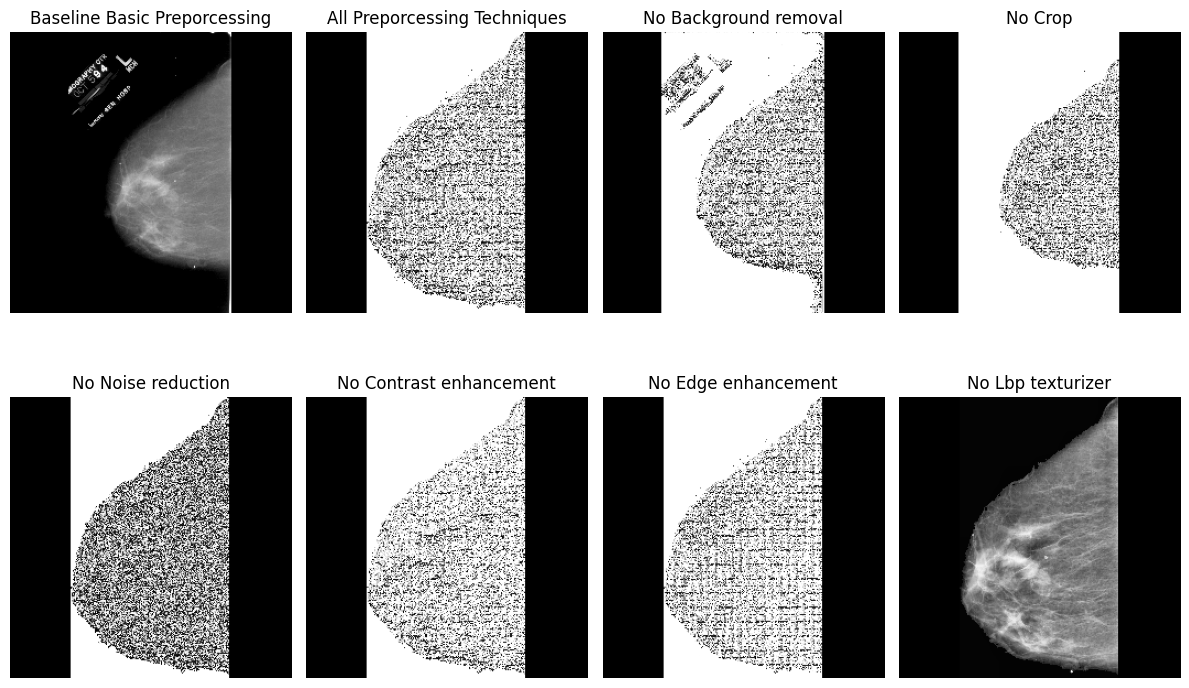

In [332]:
vis.vis_plots(preprocessed_imgs_data)

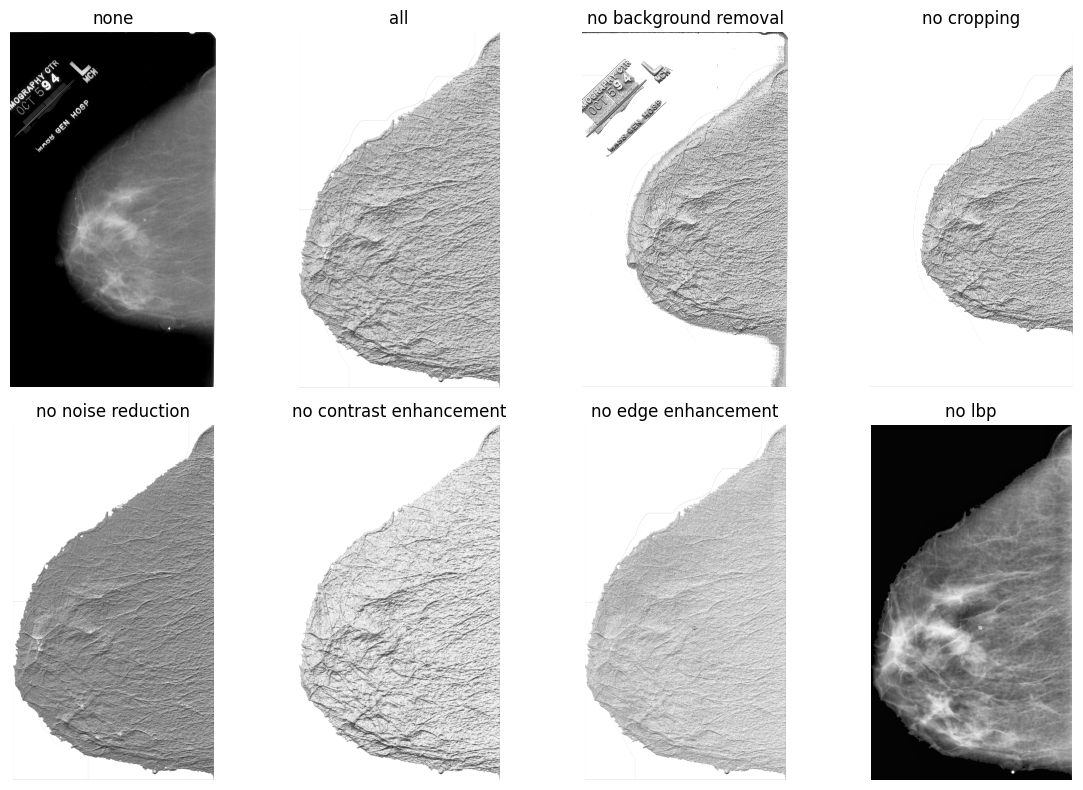

In [50]:
vis.vis_plots(prepro_imgs)